# Вращение твердого тела
Вращение твердого тела с закрепленным центром масс, описывается формулой:
$$M=J \dot{Ω}+Ω\times JΩ$$
Формула для производной кватерниона:
$$\dot{q}=\frac{1}{2}q\circ Ω$$

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import math
# Вспомогательные функции

def normalize(obj):
    return obj / np.linalg.norm(obj)


def cross_product(a, b):
    return np.array([a[1]*b[2]-a[2]*b[1], a[2]*b[0]-a[0]*b[2], a[0]*b[1] - a[1]*b[0]])

    return q

def quat2rpy(q0, q1, q2, q3):

    roll = np.arctan2(2. * (q0 * q1 + q2 * q3), 1. - 2. * (q1**2 + q2**2))
    pitch = np.arcsin(2. * (q0 * q2 - q1 * q3))
    yaw = np.arctan2(2. * (q0 * q3 + q1 * q2), 1. - 2. * (q2**2 + q3**2))

    return [roll, pitch, yaw]

#Управление
Вектор управления равен моменту силы, действующего на тело
$$u=M=Je$$
где
$$e=K_{p}u_{p}+K_{u}u_{d}+K_{i}u_{i}$$

In [65]:
def evolution(x0, T, dt, x_des, J): #возвращает траекторию
    xs = np.array([x0])
    ts = np.array([0.])
    ei=0
    while ts[-1] < T:
        x_dot, ei = model(xs[-1, :], x_des, J, dt, ei)
        x_next = xs[-1, :] + x_dot * dt
        t_next = ts[-1] + dt
        xs = np.vstack((xs, x_next))
        ts = np.append(ts, t_next)
    return ts, xs

def model(x, x_des, J, dt, ei): #возвращает изменение кватернионов и угловых скоростей
    q = x[0:4]
    w = x[4:7]

    M, ei= M_control(x, x_des, dt, ei)
    tau = M - cross_product(w, np.matmul(J, w))

    nu = np.matmul(np.linalg.inv(J), tau)
    x_dot = np.zeros((7,))
    x_dot[0] = -0.5 * q[1:4].dot(w)
    x_dot[1:4] = 0.5 * (q[0] * w + cross_product(q[1:4], w))
    x_dot[4:7] = nu
    return x_dot, ei


def M_control(x, x_des, dt, ei): #возвращает момент силы
    Kp = 2.
    Kd = 5.
    Ki = 0.01

    q = x[0:4]
    w = x[4:7]
    q_des = x_des[0:4]
    w_des = x_des[4:7]

    ep=q_des[1:]-q[1:]
    ed=w_des-w

    if q[0]*q_des[0]<0:
      if ep[0]*q_des[0]<0:
        ep[0]=-ep[0]
      if ep[1]*q_des[0]<0:
        ep[1]=-ep[1]
      if ep[2]*q_des[0]<0:
        ep[2]=-ep[2]


    M=np.matmul(J,Kp*ep+Kd*ed+Ki*ei)
    Mmax=0.05 #ограничение момента силы
    if np.linalg.norm(M)>Mmax:
        M=M/np.linalg.norm(M)*Mmax
    ei= ei + dt * ep
    return M, ei

In [83]:
t0 = 0.
tf = 70.
dt = 0.01
t_eval = np.arange(t0, tf, dt) #вектор времени

e_0=np.array([1.,0.,0.]) #начальное положение в кватернионах
e_0=normalize(e_0)
teta_0 = 1. 
if teta_0>math.pi/2:
  teta_0=teta_0-math.pi/2*math.floor(teta_0/math.pi*2)
if teta_0<-math.pi/2:
  teta_0=-(-teta_0-math.pi/2*math.floor(-teta_0/math.pi*2))

x_0=np.array([math.cos(teta_0),e_0[0]*math.sin(teta_0),e_0[1]*math.sin(teta_0),e_0[2]*math.sin(teta_0),0,0,0])

e_dest=np.array([1.,1.,7.]) #конечное положение в кватернионах
e_dest=normalize(e_dest)
teta_dest = -5.
if teta_dest>math.pi/2:
  teta_dest=teta_0-math.pi/2*math.floor(teta_dest/math.pi*2)
if teta_dest<-math.pi/2:
  teta_dest=-(-teta_0-math.pi/2*math.floor(-teta_dest/math.pi*2))
x_dest=np.array([math.cos(teta_dest),e_dest[0]*math.sin(teta_dest),e_dest[1]*math.sin(teta_dest),e_dest[2]*math.sin(teta_dest),0,0,0])

Jxx = 0.1
Jyy = 0.2
Jzz = 0.3
Jxy = 0.03
Jxz = 0.02
Jyz = 0.1
J=np.array([[Jxx, Jxy, Jxz], [Jxy, Jyy, Jyz], [Jxz, Jyz, Jzz]])

ts, xs = evolution(x_0, tf, dt, x_dest, J) #в xs кватернионы и угловие скорости

N=int(tf/dt)

#перевод в углы эйлера
roll_0=np.array([])
pitch_0=np.array([])
yaw_0=np.array([])
for i in range (N+2):
    roll, pitch, yaw=quat2rpy(xs[i,0],xs[i,1],xs[i,2],xs[i,3])
    roll_0 = np.append(roll_0, roll)
    pitch_0 = np.append(pitch_0, pitch)
    yaw_0 = np.append(yaw_0, yaw)

r, p, y=quat2rpy(x_dest[0],x_dest[1],x_dest[2],x_dest[3])

Text(0.5, 0, 'time (с)')

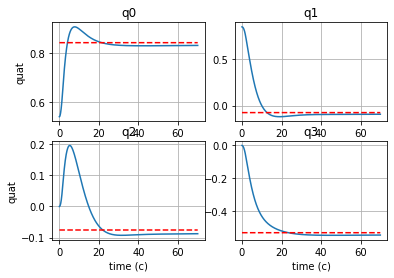

In [84]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(ts, xs[:,0])
ax1.plot(ts, np.ones_like(roll_0) * x_dest[0],'--',color ='r')
ax1.set_title('q0')
ax2.plot(ts, xs[:,1])
ax2.plot(ts, np.ones_like(roll_0) * x_dest[1],'--',color ='r')
ax2.set_title('q1')
ax3.plot(ts, xs[:,2])
ax3.plot(ts, np.ones_like(roll_0) * x_dest[2],'--',color ='r')
ax3.set_title('q2')
ax4.plot(ts, xs[:,3])
ax4.plot(ts, np.ones_like(roll_0) * x_dest[3],'--',color ='r')
ax4.set_title('q3')
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.set_ylabel('quat')
ax3.set_ylabel('quat')
ax3.set_xlabel('time (с)')
ax4.set_xlabel('time (с)')

Text(0.5, 0, 'time (с)')

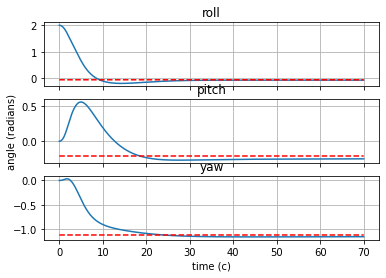

In [85]:
fig, axs = plt.subplots(3, sharex=True)
axs[0].plot(ts, roll_0)
axs[0].plot(ts, np.ones_like(roll_0) * r,'--',color ='r')
axs[0].set_title('roll') #угол собственного вращения
axs[1].plot(ts, pitch_0)
axs[1].plot(ts, np.ones_like(roll_0) * p,'--',color ='r')
axs[1].set_title('pitch') #угол нутации
axs[2].plot(ts, yaw_0)
axs[2].plot(ts, np.ones_like(roll_0) * y,'--',color ='r')
axs[2].set_title('yaw') #угол прецессии
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[1].set_ylabel('angle (radians)')
axs[2].set_xlabel('time (с)')